<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# Parameters
kms_key = "arn:aws:kms:us-west-2:521695447989:key/6e9984db-50cf-4c7e-926c-877ec47a8b25"


# Deploying pre-trained PyTorch VGG19 model with Amazon SageMaker Neo

Amazon SageMaker Neo is API to compile machine learning models to optimize them for our choice of hardward targets. Currently, Neo supports pre-trained PyTorch models from [TorchVision](https://pytorch.org/docs/stable/torchvision/models.html). General support for other PyTorch models is forthcoming.

In this example notebook, we will compare the performace of PyTorch pretrained Vgg19_bn model before versus after compilation using Neo. 

Pytorch Vgg19_bn model is one of the models that benefits a lot from compilation with Neo. Here we will verify that in end to end compilation and inference on sagemaker endpoints, Neo compiled model can get seven times speedup with no loss in accuracy.

In [2]:
!~/anaconda3/envs/pytorch_p36/bin/pip install torch==1.6.0 torchvision==0.7.0

/bin/sh: 1: /root/anaconda3/envs/pytorch_p36/bin/pip: not found


In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.8.1+cu102
0.9.1+cu102


## Import VGG19 from TorchVision

We'll import [VGG19_bn](https://arxiv.org/pdf/1409.1556.pdf) model from TorchVision and create a model artifact `model.tar.gz`:

In [1]:
import torch
import torchvision.models as models
import tarfile

In [3]:
vgg19_bn = models.vgg19_bn(pretrained=True)
input_shape = [1, 3, 224, 224]
trace = torch.jit.trace(vgg19_bn.float().eval(), torch.zeros(input_shape).float())
trace.save("model.pth")

with tarfile.open("model.tar.gz", "w:gz") as f:
    f.add("model.pth")

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


### Set up the environment

In [4]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base
from sagemaker import image_uris

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base("TorchVision-vgg19-Neo")
prefix = compilation_job_name + "/model"

model_path = sess.upload_data(path="model.tar.gz", key_prefix=prefix)

data_shape = '{"input0":[1,3,224,224]}'
target_device = "ml_c5"
framework = "pytorch"
framework_version = "1.6"
compiled_model_path = "s3://{}/{}/output".format(bucket, compilation_job_name)

inference_image_uri = image_uris.retrieve(
    f"neo-{framework}", region, framework_version, instance_type=target_device
)

### Use sagemaker PyTorchModel to load pretained PyTorch model 

In [5]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

pt_vgg = PyTorchModel(
    model_data=model_path,
    framework_version=framework_version,
    predictor_cls=Predictor,
    role=role,
    sagemaker_session=sess,
    entry_point="vgg19_bn_uncompiled.py",
    source_dir="code",
    py_version="py3",
    image_uri=inference_image_uri,
)

### Deploy the pretrained model to prepare for predictions(the old way)

In [6]:
vgg_predictor = pt_vgg.deploy(initial_instance_count=1, instance_type="ml.c5.9xlarge")

-----!

### Invoke the endpoint

Let's test with a cat image.

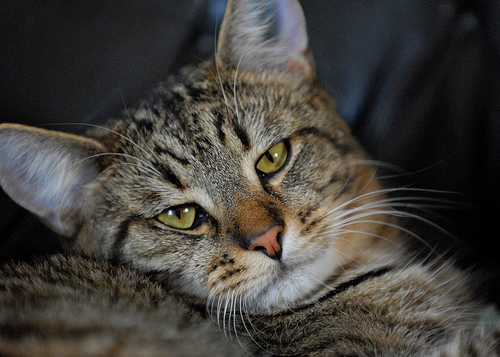

In [7]:
from IPython.display import Image

Image("cat.jpg")

#### Read the image payload

In [8]:
import json

with open("cat.jpg", "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

#### Measure Inference Lantency

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
import time

start = time.time()
for _ in range(1):
    output = vgg_predictor.predict(payload)
inference_time = time.time() - start
print("Inference time is " + str(inference_time) + "millisecond")

InternalFailure: An error occurred (InternalFailure) when calling the InvokeEndpoint operation (reached max retries: 4): An exception occurred while sending request to model. Please contact customer support regarding request 6fa5c87f-4204-48fb-9ab8-1cdd49dd6e7d.

In [13]:
import numpy as np

result = json.loads(output.decode())
predicted = np.argmax(result)

NameError: name 'output' is not defined

In [ ]:
# Load names for ImageNet classes
object_categories = {}
with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f:
        key, val = line.strip().split(":")
        object_categories[key] = val

In [ ]:
print("Result: label - " + object_categories[str(predicted)])

### Clean-up
Deleting the local endpoint when you're finished is important since you can only run one local endpoint at a time.

In [ ]:
sess.delete_endpoint(vgg_predictor.endpoint_name)

## Neo optimization

### Create a PyTorch SageMaker model

In [14]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

sagemaker_model = PyTorchModel(
    model_data=model_path,
    predictor_cls=Predictor,
    framework_version=framework_version,
    role=role,
    sagemaker_session=sess,
    entry_point="vgg19_bn_compiled.py",
    source_dir="code",
    py_version="py3",
    env={"MMS_DEFAULT_RESPONSE_TIMEOUT": "500"},
)

### Use Neo compiler to compile the model

In [19]:
data_shape

'{"input0":[1,3,224,224]}'

In [27]:
compiled_model = sagemaker_model.compile(
    target_instance_family=target_device,
    input_shape={"input0": [1, 3, 224, 224]}, #data_shape,
    job_name=compilation_job_name,
    role=role,
    framework='pytorch', #framework.upper(),
    framework_version='1.8.0', #framework_version,
    output_path=compiled_model_path,
)

ParamValidationError: Parameter validation failed:
Unknown parameter in InputConfig: "FrameworkVersion", must be one of: S3Uri, DataInputConfig, Framework

In [17]:
help(sagemaker_model.compile)

Help on method compile in module sagemaker.model:

compile(target_instance_family, input_shape, output_path, role, tags=None, job_name=None, compile_max_run=300, framework=None, framework_version=None, target_platform_os=None, target_platform_arch=None, target_platform_accelerator=None, compiler_options=None) method of sagemaker.pytorch.model.PyTorchModel instance
    Compile this ``Model`` with SageMaker Neo.
    
    Args:
        target_instance_family (str): Identifies the device that you want to
            run your model after compilation, for example: ml_c5. For allowed
            strings see
            https://docs.aws.amazon.com/sagemaker/latest/dg/API_OutputConfig.html.
            Alternatively, you can select an OS, Architecture and Accelerator using
            ``target_platform_os``, ``target_platform_arch``,
            and ``target_platform_accelerator``.
        input_shape (dict): Specifies the name and shape of the expected
            inputs for your trained model

In [ ]:
predictor = compiled_model.deploy(initial_instance_count=1, instance_type="ml.c5.9xlarge")

#### Measure Inference Lantency

In [ ]:
import time

start = time.time()
for _ in range(1000):
    response = predictor.predict(payload)
neo_inference_time = time.time() - start
print("Neo optimized inference time is " + str(neo_inference_time) + "millisecond")

In [ ]:
result = json.loads(response.decode())
print("Most likely class: {}".format(np.argmax(result)))
print(
    "Result: label - "
    + object_categories[str(np.argmax(result))]
    + " probability - "
    + str(np.amax(result))
)

In [ ]:
sess.delete_endpoint(predictor.endpoint_name)